# Measuring spectra

Some required imports, nothing fancy.

In [1]:
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl

Now the Heracles imports:

* The top-level `heracles` module contains all general user-facing functionality.
* The `heracles.healpy` module contains functionality for mapping catalogues to HEALPix maps with the `healpy` package.

In [2]:
import heracles
import heracles.healpy

## Catalogues

Heracles provides a flexible interface for loading catalogues from FITS files or arrays. It also provides a base that can quickly be extended e.g. to databases or more.

Here we use the FITS interface to read a catalogue from file. We could specify the columns to read, but we don't do that here, because the catalogue only has columns of interest here.

Catalogues are never read into memory all at once. Their `page_size` property determines how many rows are read at a time.

In [3]:
# create the FITS catalogue
catalog = heracles.FitsCatalog("catalog.fits")

Using the `add_filter()` method, we could add filters to the catalogue here which, e.g., strip rows with invalid values, or apply an extra footprint mask to the catalogue. Since we made our catalogue ourselves, that won't be necessary here.

## Footprint

Some statistics and normalisations require knowledge of the survey footprint. We load our previously saved footprint map and associate it with the catalogue.

In [4]:
# set visibility of the catalogue
catalog.visibility = hp.read_map("footprint.fits.gz")

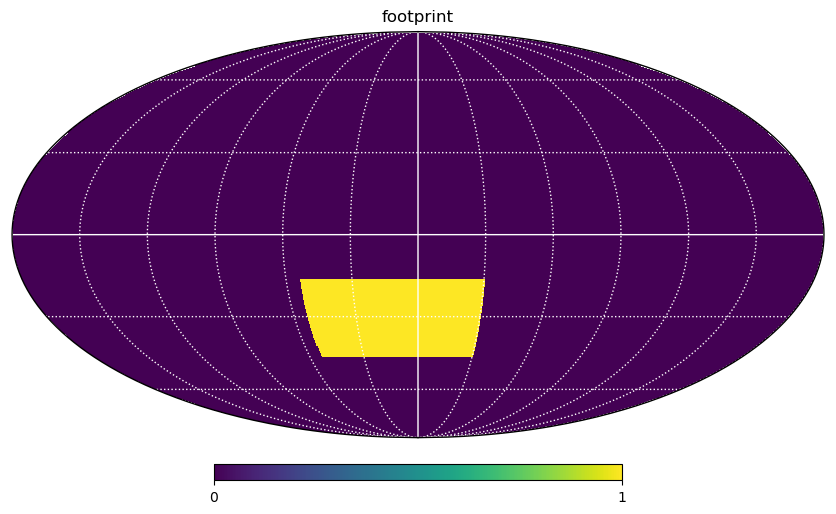

In [5]:
# make sure the map is as expected
hp.mollview(catalog.visibility, title="footprint")
hp.graticule(c="w")
plt.show()

## Tomographic binning

The `catalog` object as it is would read the entire catalogue.
To split the catalogue up into our individual tomographic bins, we construct a dictionary that assigns a bin ID to a subselection of the catalogue. This is done using the usual `[...]` syntax, which returns a new view of the catalogue with the given selection applied.

In [6]:
catalogs = {
    binid: catalog[f"BIN == {binid}"]
    for binid in range(1, 7)
}

In [7]:
catalogs

{1: catalog.fits['BIN == 1'],
 2: catalog.fits['BIN == 2'],
 3: catalog.fits['BIN == 3'],
 4: catalog.fits['BIN == 4'],
 5: catalog.fits['BIN == 5'],
 6: catalog.fits['BIN == 6']}

## Fields

To turn catalogues into spectra, Heracles requires a so-called mapper object.
Here, we construct a `HealpixMapper` instance with our desired NSIDE (i.e., resolution) and LMAX (i.e., number of angular modes) parameters.

In [8]:
# resolution and angular modes
nside = 1024
lmax = 2000

In [9]:
# construct a mapper that produces HEALPix maps
mapper = heracles.healpy.HealpixMapper(nside, lmax)

To specify the fields we wish to analyse, we construct a dictionary of keys and field definitions.
A field requires a mapper and a list of columns, plus potentially some other options.

Here, we construct a field `"G"` for our simulated cosmic shear, using the column names from the catalogue that we wrote. The `mask="W"` parameter can be ignored for the time being.

In [10]:
# construct a dictionary for the fields to be analysed
fields = {
    "G": heracles.Shears(mapper, "RA", "DEC", "E1", "E2", mask="W"),
}

## Mapping

The next step is to map the catalogues to the shear field for each tomographic bin. Heracles can map a set of catalogues all at once, using the `map_catalogs()` function. We only need to pass in the fields and catalogues constructed previously.

In [11]:
# create tomographic maps from fields and catalogs
maps = heracles.map_catalogs(fields, catalogs, parallel=True, progress=True)

Output()

The resulting `maps` dictionary has keys consisting of the field (`"G"`) and catalogue (`1`, `2`, ...), and values which are two HEALPix maps for the two shear components.

In [12]:
for key, value in maps.items():
    print("key", key, "contains maps of shape", value.shape)

key ('G', 1) contains maps of shape (2, 12582912)
key ('G', 2) contains maps of shape (2, 12582912)
key ('G', 3) contains maps of shape (2, 12582912)
key ('G', 4) contains maps of shape (2, 12582912)
key ('G', 5) contains maps of shape (2, 12582912)
key ('G', 6) contains maps of shape (2, 12582912)


Let's have a quick look at the results in bin 3!

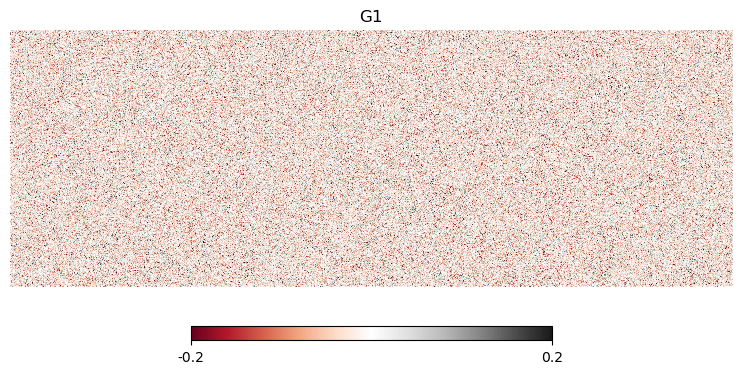

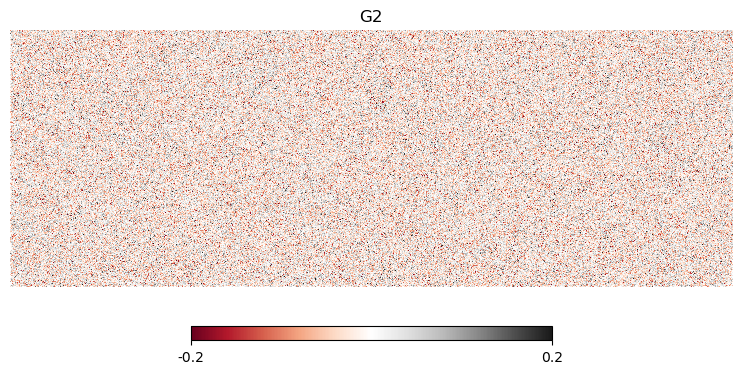

In [13]:
binid = 3

hp.cartview(maps["G", binid][0], title="G1", cmap='RdGy', min=-0.2, max=0.2,
            lonra=[329.5, 53.5], latra=[-45.6, -15.7])
plt.show()

hp.cartview(maps["G", binid][1], title="G2", cmap='RdGy', min=-0.2, max=0.2,
            lonra=[329.5, 53.5], latra=[-45.6, -15.7])
plt.show()

## Spherical harmonic coefficients

To extract the two-point information, we transform the real-space maps we created into harmonic space using the `transform()` function.

In [14]:
# transform maps to harmonic space, using the mapper from fields
alms = heracles.transform(fields, maps, progress=True)

Output()

The resulting `alms` dictionary has the same keys as `maps`, but now contains the spherical harmonic coefficients in the particular format that HEALPix uses, which has become the de facto standard. As with the maps, there are two sets of coefficients for each tomographic bin, containing the *E*-mode and *B*-mode of the field.

In [15]:
for key, value in alms.items():
    print("key", key, "contains alms of shape", value.shape)

key ('G', 1) contains alms of shape (2, 2003001)
key ('G', 2) contains alms of shape (2, 2003001)
key ('G', 3) contains alms of shape (2, 2003001)
key ('G', 4) contains alms of shape (2, 2003001)
key ('G', 5) contains alms of shape (2, 2003001)
key ('G', 6) contains alms of shape (2, 2003001)


## Two-point statistics

We are now able to compute the two-point statistics in the form of angular power spectra. To do so, we simply call the `angular_power_spectra()` function on `alms`. The function removes the noise bias from the spectra (unless `debias=False` is passed) and can optionally compute binned spectra (using the `bins=` and `weights=` parameters).

In [16]:
# compute spectra from all combinations of alms
cls = heracles.angular_power_spectra(alms)

This returns all combinations of spherical harmonic coefficients. They are many, arranged in a dictionary with entries such as `("G_E", "G_B", 5, 4) for the *E*-mode and *B*-mode cross-power spectrum between bin IDs 5 and 4 (in order).

In [17]:
print("there are", len(cls), "spectra, starting with", list(cls.keys())[:3])

there are 78 spectra, starting with [('G_E', 'G_E', 1, 1), ('G_E', 'G_B', 1, 1), ('G_E', 'G_E', 1, 2)]


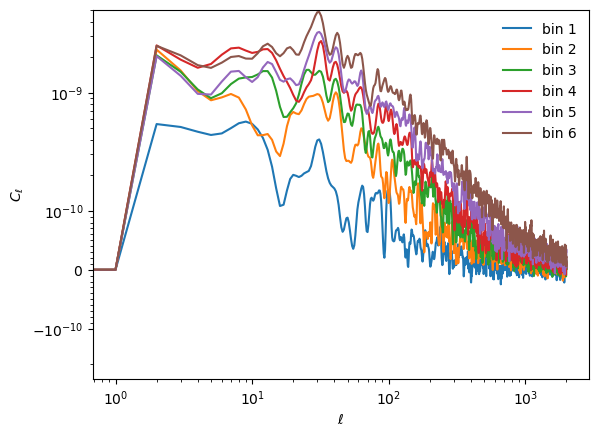

In [18]:
# print the spectra of the E-mode auto-correlations
for binid in range(1, 7):
    plt.plot(
        np.arange(lmax + 1),
        cls["G_E", "G_E", binid, binid],
        label=f"bin {binid}",
    )
plt.legend(frameon=False)
plt.xscale("log")
plt.yscale("symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
plt.xlabel("$\\ell$")
plt.ylabel("$C_\\ell$")
plt.show()

> Why does the signal suddenly drop to zero on the left?

## Theory

We can now compute the theoretical expectation of the angular power spectra. To do so, we use CAMB again.

In [19]:
import camb
from camb.sources import SplinedSourceWindow

# cosmology for the analysis
h = 0.67
Oc = 0.27
Ob = 0.05
As = 2.2e-9

# set up CAMB parameters
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, As=As,
                       NonLinear=camb.model.NonLinear_both)
pars.lmin = 1
pars.Want_CMB = False
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

We load the tomographic redshift distribution of the simulation, and use it to create window functions for the theory lensing spectra.

In [20]:
# load the redshift distributions
with np.load("nz.npz") as npz:
    z = npz["z"]
    nz = npz["nz"]

# create distributions for CAMB
sources = []
for i in range(len(catalogs)):
    source = SplinedSourceWindow(source_type='lensing', z=z, W=nz[i])
    sources.append(source)
pars.SourceWindows = sources

Compute the full sky theory spectra up to `lmax`.

In [21]:
# compute spectra with CAMB, using raw_cl to remove l*(l+1) scaling
camb_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

CAMB's lensing spectra are for the convergence, not the shear. We can compute an ell-dependent scaling that converts between the two.

In [22]:
ell = np.arange(lmax + 1)
fl = -np.sqrt((ell + 2) * (ell + 1) * ell * (ell - 1))
fl /= np.clip(ell * (ell + 1), 1, None)

To make the comparison easier, we can store the CAMB results in the same dictionary structure as our measurement.

In [23]:
# use the data structure from Heracles, which allows slicing like this: theory_cls["G_E", "G_E"]
theory_cls = heracles.TocDict()
for i in range(1, 7):
    for j in range(i, 7):
        # what CAMB calls the sources
        cl = camb_cls[f"W{i}xW{j}"]

        # include the conversion factor in the E-mode spectrum
        theory_cls["G_E", "G_E", i, j] = cl #* fl**2

        # theory predicts zero B-modes to a very good approximation
        theory_cls["G_B", "G_B", i, j] = np.zeros(lmax + 1)
        theory_cls["G_E", "G_B", i, j] = np.zeros(lmax + 1)
        theory_cls["G_B", "G_E", i, j] = np.zeros(lmax + 1)

Finally, we can compare our measurements with the expectation!

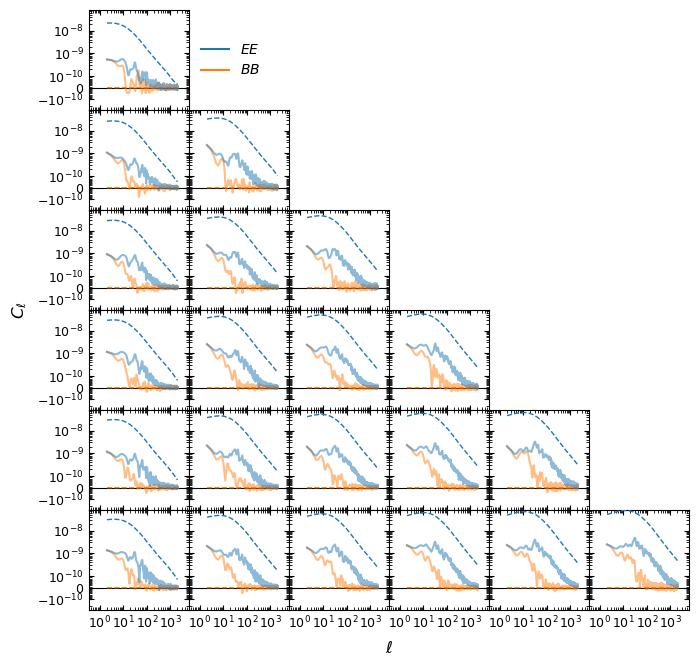

In [24]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6), sharex=True, sharey=True)
fig.tight_layout(pad=0.0)

for i in range(1, 7):
    for j in range(1, 7):
        try:
            ax[j - 1, i - 1].plot(ell[2:], cls["G_E", "G_E", i, j][2:], c="C0", lw=1.5, zorder=3.0, alpha=0.5)
            ax[j - 1, i - 1].plot(ell[2:], cls["G_B", "G_B", i, j][2:], c="C1", lw=1.5, zorder=1.0, alpha=0.5)
        except KeyError:
            ax[j - 1, i - 1].axis("off")
        else:
            ax[j - 1, i - 1].plot(ell[2:], theory_cls["G_E", "G_E", i, j][2:], c="C0", lw=1.0, ls="--", zorder=4.0)
            ax[j - 1, i - 1].plot(ell[2:], theory_cls["G_B", "G_B", i, j][2:], c="C1", lw=1.0, ls="--", zorder=2.0)
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in", labelsize=9.0,
                                         top=True, bottom=True, left=True, right=True)

ax[0, 1].legend(
    handles=[
        plt.Line2D([0], [0], c="C0", label="$EE$"),
        plt.Line2D([0], [0], c="C1", label="$BB$"),
    ],
    loc="center left",
    frameon=False,
)

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_yscale("symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_ylim(-3e-10, None)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("$\\ell$", y=-0.05, va="top")
fig.supylabel("$C_\\ell$", x=-0.1, ha="right")

plt.show()

As we can see, our measurement does not match expectations at all!

> What two major discrepancies do you see between theory and observations?

> What is the ratio between theory and observation for the *EE* spectrum? Does this number remind you of something you calculated earlier?

## Mixing matrices

In [25]:
# mapper using twice the resolution and max scale
mapper2 = heracles.healpy.HealpixMapper(2 * nside, 2 * lmax)

In [26]:
# fields for weights
fields2 = {
    "W": heracles.Weights(mapper2, "RA", "DEC"),
}

In [27]:
maps2 = heracles.map_catalogs(fields2, catalogs, parallel=True, progress=True)

Output()

In [28]:
alms2 = heracles.transform(fields2, maps2, progress=True)

Output()

In [29]:
cls2 = heracles.angular_power_spectra(alms2)

In [30]:
mms = heracles.mixing_matrices(fields, cls2, l1max=lmax, l2max=lmax, progress=True)

Output()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [31]:
# compute the spectra while modelling the impact of the mask
model_cls = heracles.TocDict()
for i in range(1, 7):
    for j in range(i, 7):
        cl_ee = theory_cls["G_E", "G_E", i, j]
        cl_bb = theory_cls["G_B", "G_B", i, j]
        cl_eb = theory_cls["G_E", "G_B", i, j]
        cl_be = theory_cls["G_B", "G_E", i, j]
        model_cls["G_E", "G_E", i, j] = mms["G_E", "G_E", i, j] @ cl_ee + mms["G_B", "G_B", i, j] @ cl_bb
        model_cls["G_B", "G_B", i, j] = mms["G_B", "G_B", i, j] @ cl_ee + mms["G_E", "G_E", i, j] @ cl_bb
        model_cls["G_E", "G_B", i, j] = mms["G_E", "G_B", i, j] @ cl_eb
        model_cls["G_B", "G_E", i, j] = mms["G_E", "G_B", i, j] @ cl_be

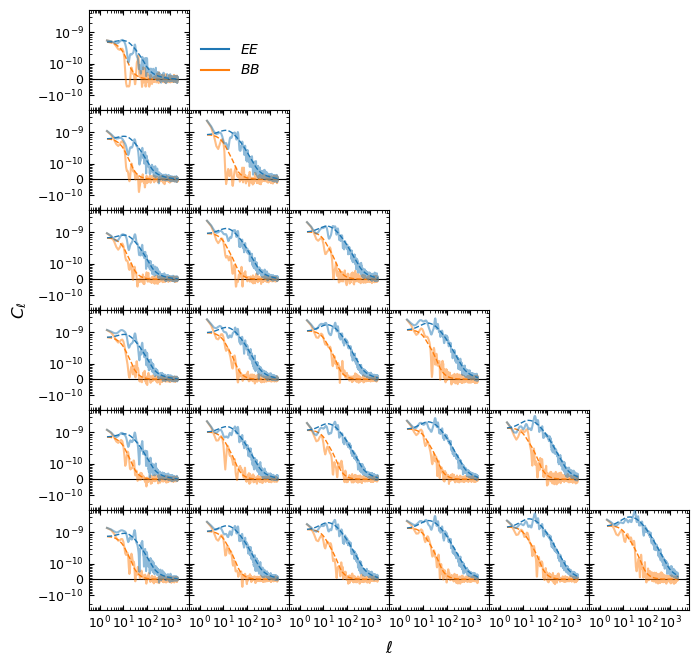

In [32]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6), sharex=True, sharey=True)
fig.tight_layout(pad=0.0)

for i in range(1, 7):
    for j in range(1, 7):
        try:
            ax[j - 1, i - 1].plot(ell[2:], cls["G_E", "G_E", i, j][2:], c="C0", lw=1.5, zorder=3.0, alpha=0.5)
            ax[j - 1, i - 1].plot(ell[2:], cls["G_B", "G_B", i, j][2:], c="C1", lw=1.5, zorder=1.0, alpha=0.5)
        except KeyError:
            ax[j - 1, i - 1].axis("off")
        else:
            ax[j - 1, i - 1].plot(ell[2:], model_cls["G_E", "G_E", i, j][2:], c="C0", lw=1.0, ls="--", zorder=4.0)
            ax[j - 1, i - 1].plot(ell[2:], model_cls["G_B", "G_B", i, j][2:], c="C1", lw=1.0, ls="--", zorder=2.0)
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in", labelsize=9.0,
                                         top=True, bottom=True, left=True, right=True)

ax[0, 1].legend(
    handles=[
        plt.Line2D([0], [0], c="C0", label="$EE$"),
        plt.Line2D([0], [0], c="C1", label="$BB$"),
    ],
    loc="center left",
    frameon=False,
)

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_yscale("symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_ylim(-3e-10, None)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("$\\ell$", y=-0.05, va="top")
fig.supylabel("$C_\\ell$", x=-0.1, ha="right")

plt.show()

## Inference

We could, at this point, use our measurement and theoretical prediction to run an inference pipeline for the cosmological parameters. While we don't have the time to do this properly, we can still do a little experiment.

> If you look very carefully at our last plot, you might notice that there is still a small but systematic discrepancy between theory and observation. The reason is in this notebook. Can you find it?

<details>
<summary>Bonus question: Only open this after you tried your hand at the previous question.</summary>
<blockquote>
    You might have noticed that we are using different cosmology parameters here than in the simulation. In particular, we are setting the <code>As</code> parameter to a value here, but left it at its default value in the simulation. Restoring the other parameters to their simulated values, can you discover what CAMB's default value of <code>As</code> might be without looking it up?
</blockquote>
</details>